In [1]:
import pandas as pd
import mlflow
import os
import sys
import mlflow.sklearn
from pycaret.classification import *

In [2]:
# Used this code to operate mlflow ui as something is missing from original mlflow ui
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 --port 5000

In [3]:
print(mlflow.__version__)

2.15.1


# Introduction
Below codes will meet the wheat seeds business objective by training a classification model to predict the type of wheat based on kernel attributes.<br>
Evaluating the model using key performance metrics and <br>
Logging the model and experiment details in mlflow for future references and reproducibity

## Configure mlflow for remote experiment tracking
In here , i have set the mlflow tracking uri to make sure that the mlflow tracking server is running.

In [4]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
# # Create MLflow Experiment , ignore this.
# experiment_name = "wheat_classification_new"
# mlflow.set_experiment(experiment_name)

2025/02/27 16:59:36 INFO mlflow.tracking.fluent: Experiment with name 'wheat_classification_new' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/860820815833894395', creation_time=1740646776156, experiment_id='860820815833894395', last_update_time=1740646776156, lifecycle_stage='active', name='wheat_classification_new', tags={}>

## Load dataset
Added codes to ensure that the dataset file exists before going on <br>
The dataset path would be 03_Wheat_Seeds.csv

In [5]:
dataset_path = "03_Wheat_Seeds.csv"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset file '{dataset_path}' not found.")

df = pd.read_csv(dataset_path)
df.head()

,Area,Perimeter,Compactness,Length,Width,AsymmetryCoeff,Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## Pycaret setup
- Scales numerical features
- selects the most important features
- bins continuous numerical variables into intervals for feature engineering
- auto logging is disabled as mlflow logging will be handled manually later ( something is wrong with my version)
- This code target variable is 'type' which represents the 3 wheat varieties.
- Applied normalization to numeric features
- Set up random seed for reproducibility to be 42

In [6]:
clf_setup = setup(
    data=df,
    target="Type",
    normalize=True,            
    feature_selection=True,    
    bin_numeric_features=["Area", "Perimeter", "Length", "Width", "Groove"],  
    session_id=42,
    log_experiment= True,
    experiment_name = "wheatclassification",
)


,Description,Value
0,Session id,42
1,Target,Type
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(199, 8)"
5,Transformed data shape,"(199, 2)"
6,Transformed train set shape,"(139, 2)"
7,Transformed test set shape,"(60, 2)"
8,Numeric features,7
9,Preprocess,True


## Model training and selection
Selects the best model using accuracy as the metric and compare different models
- Uses cross validation to evaluate on each model

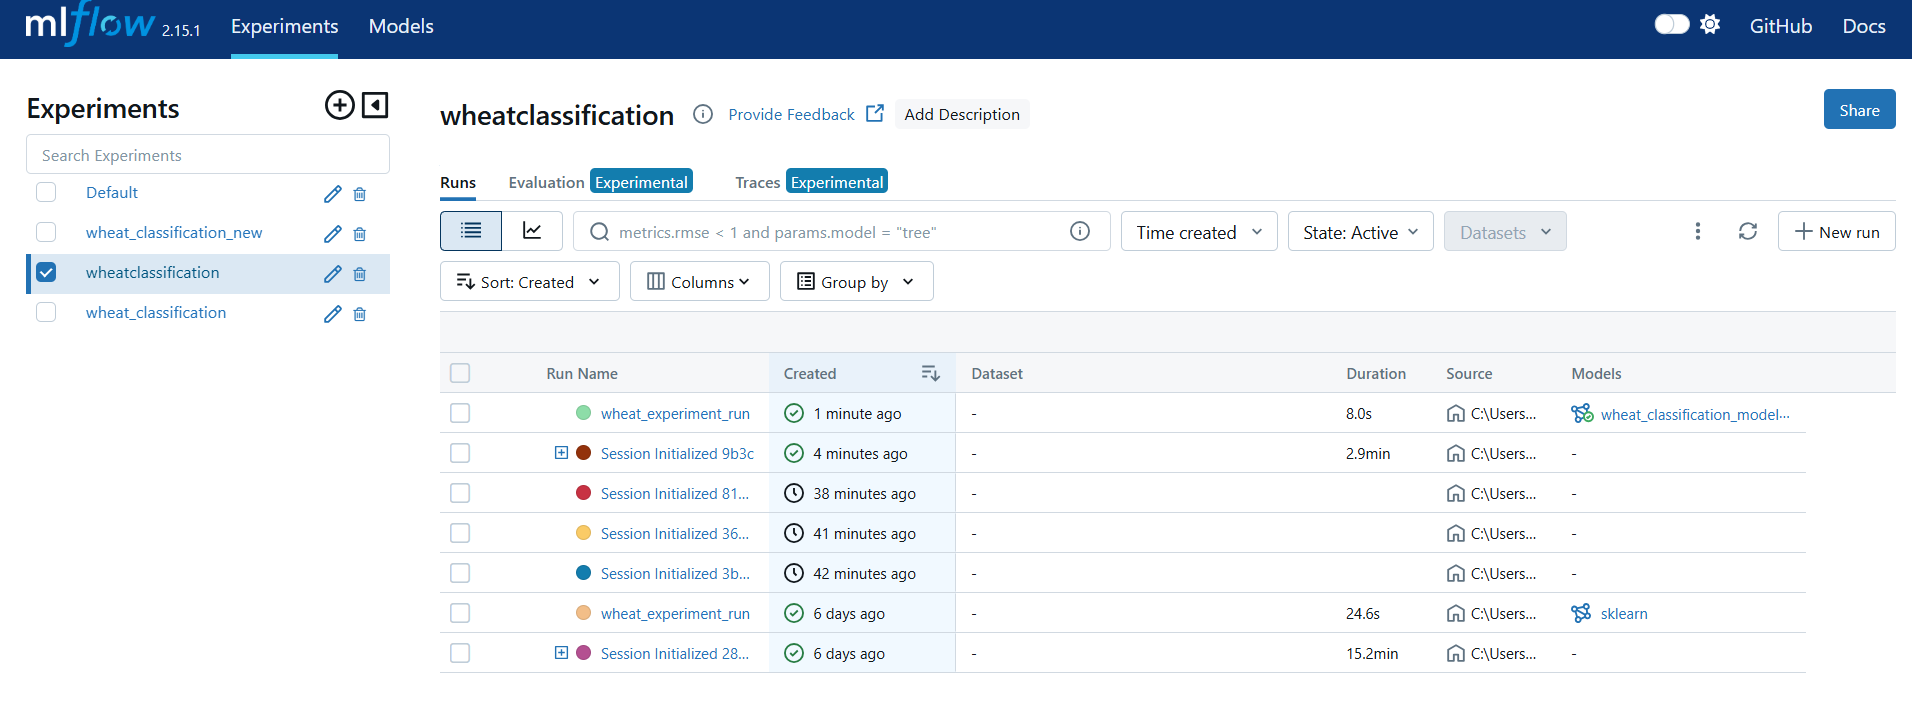

In [7]:
best_model = compare_models(sort="Accuracy")


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5676,0.7605,0.5676,0.5854,0.5560,0.3521,0.3645,0.4500
qda,Quadratic Discriminant Analysis,0.5676,0.0000,0.5676,0.5854,0.5560,0.3521,0.3645,0.4230
ridge,Ridge Classifier,0.5670,0.0000,0.5670,0.4669,0.4789,0.3539,0.4110,0.4150
lr,Logistic Regression,0.5604,0.0000,0.5604,0.5763,0.5490,0.3420,0.3537,1.4830
lda,Linear Discriminant Analysis,0.5604,0.0000,0.5604,0.5759,0.5504,0.3407,0.3507,0.4370
xgboost,Extreme Gradient Boosting,0.4890,0.6757,0.4890,0.5592,0.4698,0.2321,0.2564,0.7630
ada,Ada Boost Classifier,0.4813,0.0000,0.4813,0.5012,0.4594,0.2252,0.2360,0.5460
dt,Decision Tree Classifier,0.4747,0.6030,0.4747,0.4906,0.4621,0.2120,0.2216,0.4080
rf,Random Forest Classifier,0.4747,0.6598,0.4747,0.4906,0.4621,0.2120,0.2216,0.6560
gbc,Gradient Boosting Classifier,0.4747,0.0000,0.4747,0.4896,0.4622,0.2120,0.2212,0.7110


2025/02/27 17:02:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/02/27 17:02:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Naive Bayes at: http://127.0.0.1:5000/#/experiments/340515399127881291/runs/1e214b0f8afb4202905e2449cb48bd5f.
2025/02/27 17:02:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/340515399127881291.
2025/02/27 17:02:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/02/27 17:02:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run Quadratic Discriminant Analysis at: http://127.0.0.1:5000/#/experiments/340515399127881291/runs/86e30c39759c4d348298e7f8f91ba9db.
2025/02/27 17:02:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experi

## Model evaluation
- Evaluate the best model performance using the evaluate_model function
- Generates confusion matrix and roc-auc to see whats in the data
- Plots feature importance to see which feature is important.

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

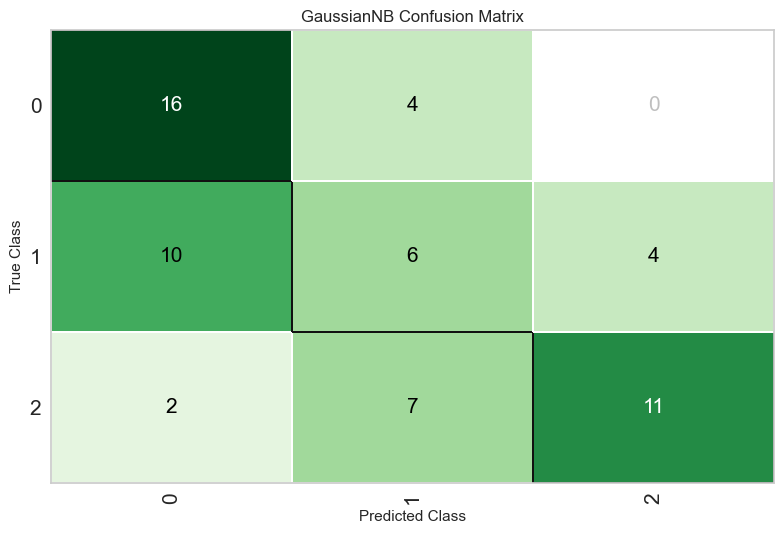

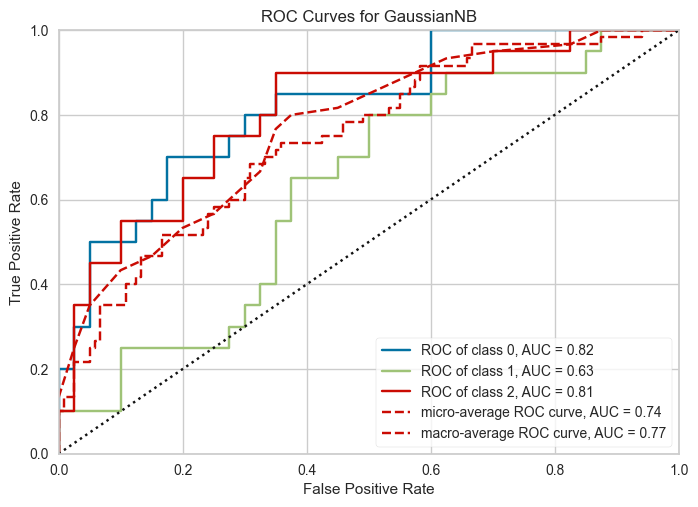

Feature Importance plot skipped as model does not support it.


In [8]:
evaluate_model(best_model) #provides an interactive ui with multiple evaluation metrics

#generate a few plots to see the model performance analysis manually
plot_model(best_model, plot="confusion_matrix") #confusion matrix
plot_model(best_model, plot="auc") #auc roc curve for classificaiton performance.

# Plot feature importance only if the selected model supports it
if hasattr(best_model, "coef_") or hasattr(best_model, "feature_importances_"):
    plot_model(best_model, plot="feature")
else:
    print("Feature Importance plot skipped as model does not support it.")


## Generate predictions on test data
- Generates prediction on unseen data to test model generalization

In [9]:
predictions = predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.5500,0.7521,0.5500,0.5526,0.5399,0.3250,0.3318


## mlflow
- Start mlflow and save the models hyperparameters
- Retrieve the log performance metrics  , save and register model in mlflow
- Added codes to handle error

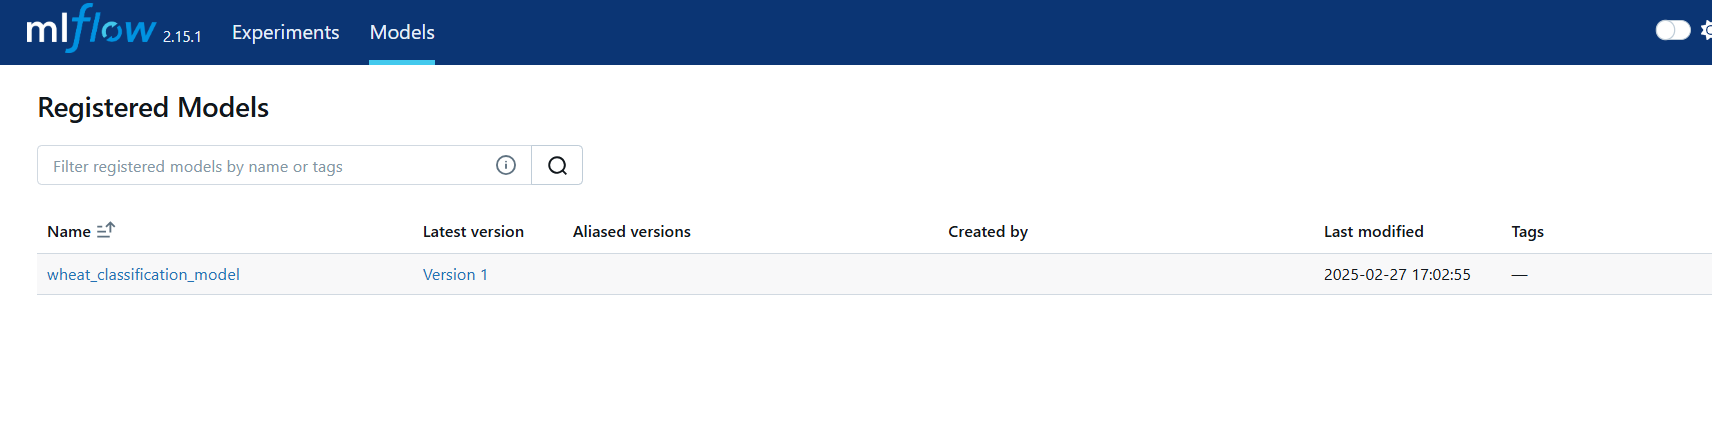

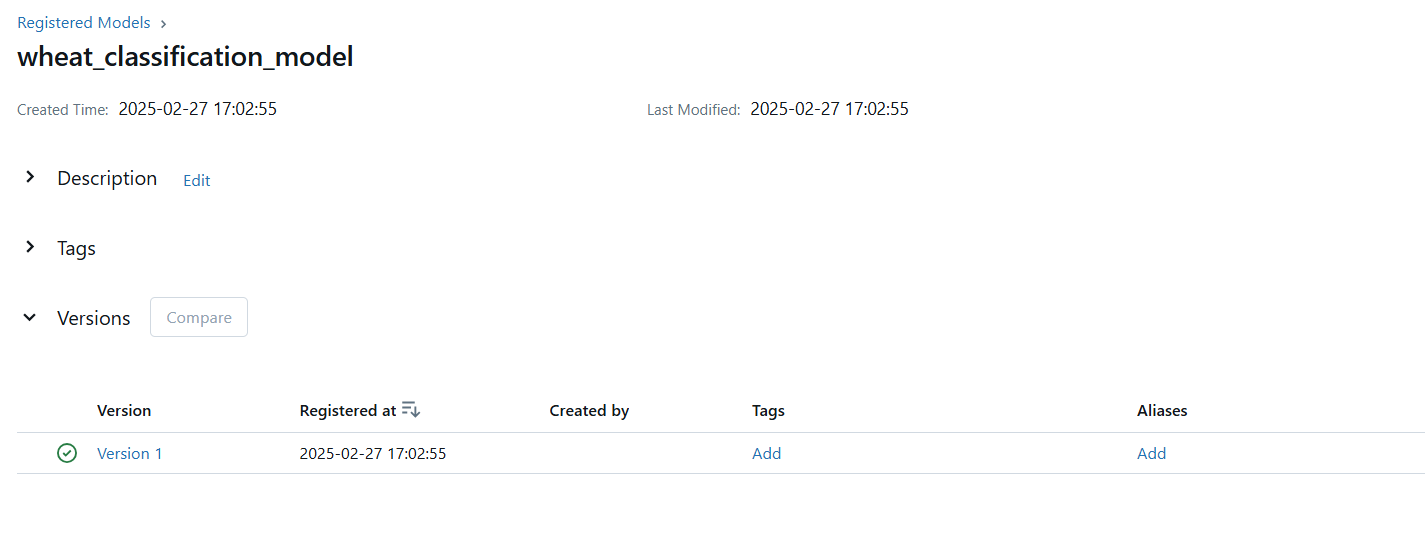

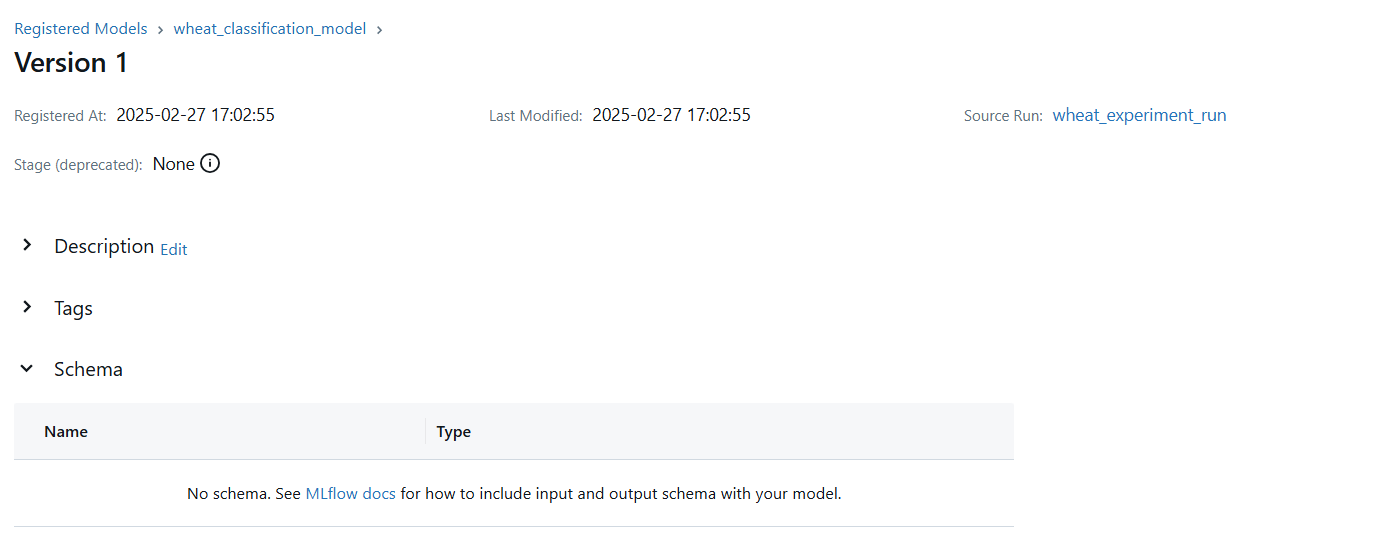

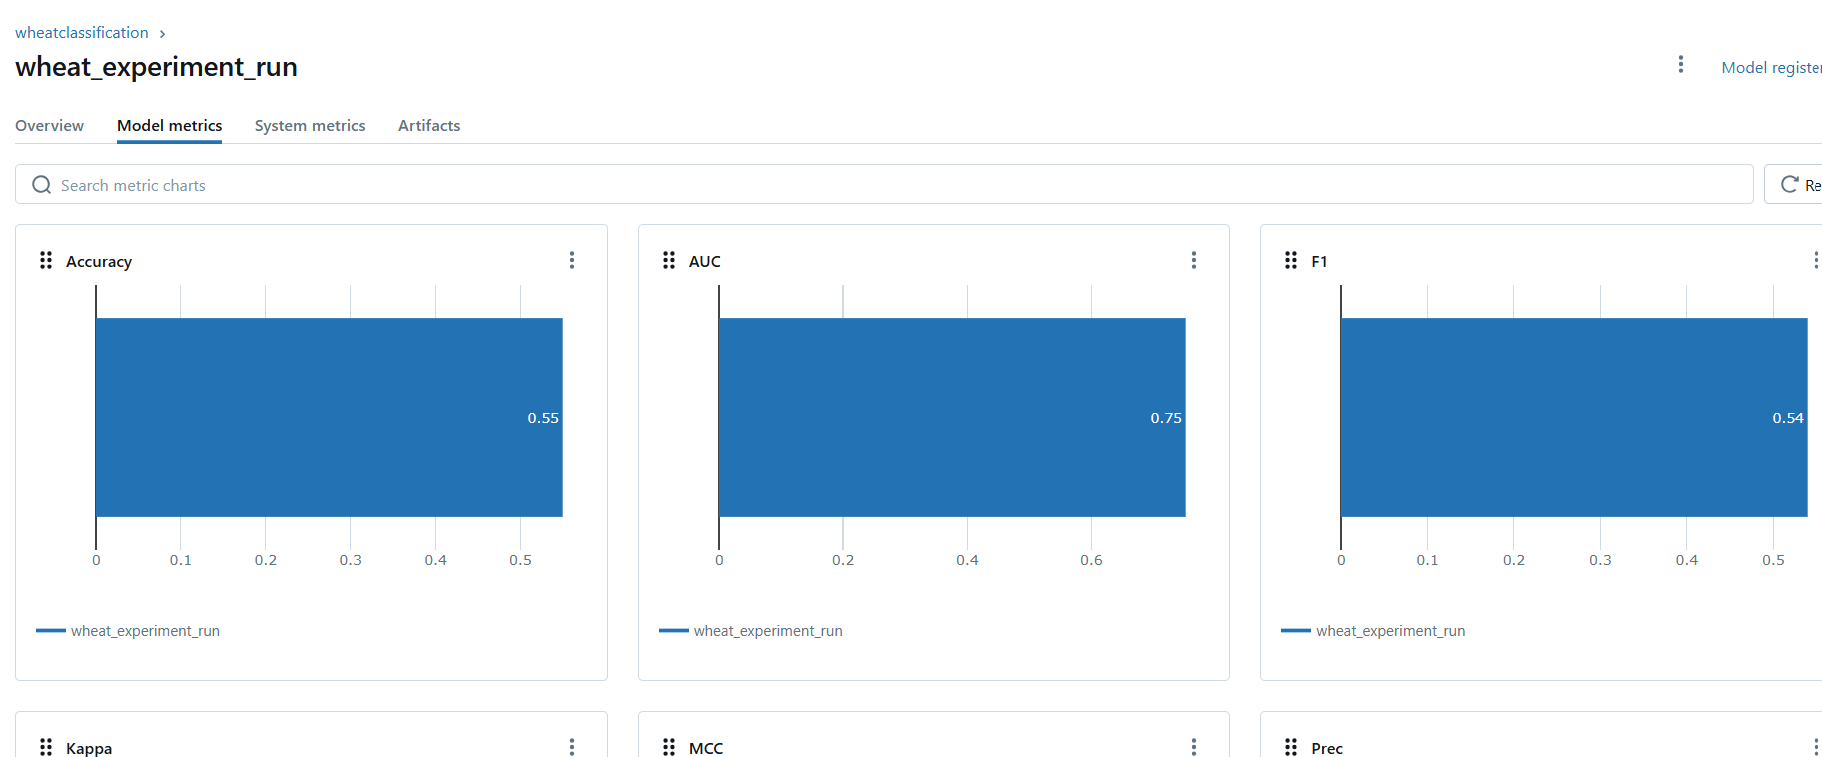

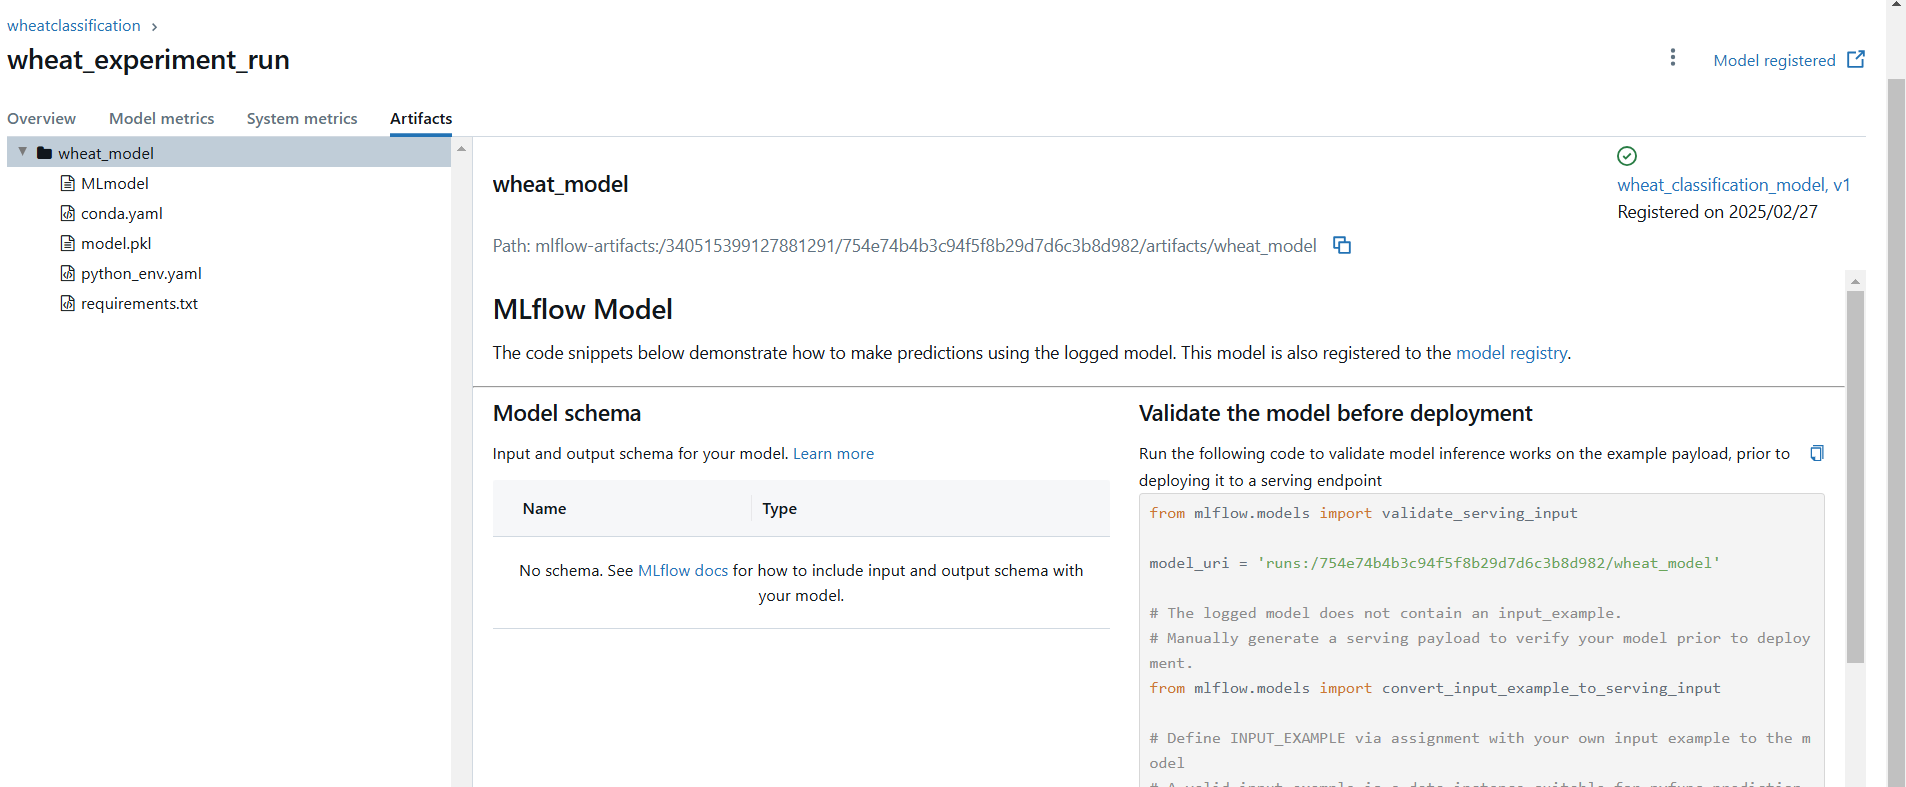

In [10]:
while mlflow.active_run():
    mlflow.end_run()
import distutils

2025/02/27 17:02:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Session Initialized 9b3c at: http://127.0.0.1:5000/#/experiments/340515399127881291/runs/0c9a379add1c4db5b06c32049458d20a.
2025/02/27 17:02:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/340515399127881291.


In [11]:
mlflow.end_run()

model_name = "wheat_classification_model"

# Start MLflow logging
with mlflow.start_run(run_name="wheat_experiment_run") as run:
    try:
        if hasattr(best_model, "get_params"):
            mlflow.log_params(best_model.get_params())

        metrics = pull()
        if metrics is not None and not metrics.empty:
            numeric_metrics = metrics.select_dtypes(include=['number']).iloc[0].to_dict()
            mlflow.log_metrics(numeric_metrics)

        model_artifact_path = "wheat_model"
        model_uri = f"runs:/{run.info.run_id}/{model_artifact_path}"

        final_model = finalize_model(best_model)

        # Log the final model in MLflow
        mlflow.sklearn.log_model(final_model, artifact_path=model_artifact_path)

        # Register the model in MLflow Model Registry
        registered_model = mlflow.register_model(
            model_uri=model_uri,  
            name=model_name
        )

        # Log model registry details
        mlflow.log_param("registered_model_name", model_name)
        mlflow.log_param("registered_model_version", registered_model.version)

        print(f"Model registered in MLflow as version {registered_model.version}")

    except Exception as e:
          print(f"Error occurred during MLflow logging: {e}")

2025/02/27 17:02:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/02/27 17:02:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run Naive Bayes at: http://127.0.0.1:5000/#/experiments/340515399127881291/runs/764eec1ac45e4a71bd629ab621d348a6.
2025/02/27 17:02:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/340515399127881291.
2025/02/27 17:02:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
Successfully registered model 'wheat_classification_model'.
2025/02/27 17:02:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: wheat_classification_model, version 1
Created version '1' of model 'wheat_classification_model'.
2025/02/27 17:02:55 INFO 

Model registered in MLflow as version 1


## saving model for task 3 usage

In [12]:
save_model(final_model, 'final_wheat_seeds_model')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Area', 'Perimeter', 'Compactness',
                                              'Length', 'Width',
                                              'AsymmetryCoeff', 'Groove'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_va...
                                                                                          min_child_weight=0.001,
                                                                                          min_split_gain=0.0,
  